In [16]:
import numpy as np
import matplotlib.pyplot as plt

# 2: Problem Formulation

"We consider the special case where r is constant. (What if r is not constant?)
The problem is then to compute
$$
\frac{V_{t_0}(S_{t_0})}{B_{t_0}} = \max_{\tau}(\mathbb{E}\frac{h(S_\tau)}{B_\tau})."
$$

In [17]:
from DiscretizationSchemes import discretizationScheme, StockpriceGBM # consider different discretization schemes?
from intrinsicOptionValues import call, put # consider more payoffs?


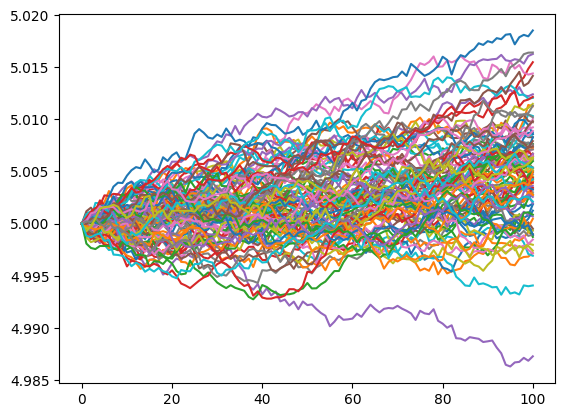

In [18]:
# check discretizationscheme
mu = 0.001
sigma = 0.01
start_price = 5
times = np.linspace(0,1,101) # monitoring dates
N = 100
for i in range(N):
    plt.plot(discretizationScheme(times, start_price, mu, sigma))

### Lokeshwar, p4: Optimization problem (1)

In [19]:
from scipy import optimize

In [20]:
# compute for a call with strike K=5
K = 100
def h(S_T):
    return call(S_T,K)

# "Generate Stm (n) for paths n = 1,...,N, m = 0,...,M" (option price should not depend on mu?)
S0, mu, sigma = 100, 0.09, 0.3
r = 0.05 # constant risk free rate
T=1
M = 52
monitoring_dates = np.linspace(0,T,M) # does not have to be evenly spaced
N = 100
sampleS = []
for i in range(N):
    sampleS.append(discretizationScheme(monitoring_dates, S0, mu, sigma))
sampleS = np.matrix(sampleS)

# "Evaluate final time option value for each path."
sampleV = np.zeros_like(sampleS)
for n in range(N):
    S_T = sampleS[n,M-1]
    sampleV[n,M-1] = max(h(S_T),0)

# Initialize βtM from uniform distribution.
d = 1 # in this case the Markovian process is a single stock price
p = 10 # number of neurons, see Hornik et al for a reasonable value
Np = p*d + p + p + 1
betas = np.zeros((M,Np))
betas[M-1] = np.random.uniform(0,1,Np) # ReLU only learns from positive values

def G(beta,S_t):
    A1S_T = S_t * beta[:p] + beta[p:p+p]
    phiA1S_T = np.maximum(A1S_T, np.zeros_like(A1S_T))
    W2 = np.array([beta[p+p:p+p+p]])
    A2phiA1S_T = np.dot(W2,phiA1S_T.transpose()) + beta[p+p+p]
    psiA2phiA1S_T = A2phiA1S_T
    return psiA2phiA1S_T[0] # [0,0]?

def Expectation_G_given_Stminus1(beta,Stminus1,N):
  avgG = 0
  for n in range(N):
    St = StockpriceGBM(1/N, Stminus1, mu, sigma)
    avgG += G(beta, St) / N
  return avgG

def target(beta, S_t, V_t):
    return (1/N) * sum([(V_t[n] - G(beta, S_t[n]))**2 for n in range(N)])

# Regress later
for i in range(M-1, 0, -1):
  print(i)
  # fit the network
  fit = optimize.minimize(target, x0=betas[i,:], args=(sampleS[:,i], sampleV[:,i])) # specify method?
  
  if fit.success:
      betas[i-1] = fit.x
  else:
      print(fit.message)

  # estimate continuation value Qti(n), get estimated option value Vti(n)
  for n in range(N):
    Btiminus1 = np.exp(-r*T/N)
    Qtiminus1 = Btiminus1 * Expectation_G_given_Stminus1(betas[i-1,:], sampleS[n,i-1], 100)
    if h(sampleS[n,i-1]) > Qtiminus1:
      sampleV[n,i-1] = h(sampleS[n,i-1])
    else:
      sampleV[n,i-1] = Qtiminus1
  
  # initialize parameters for next training
  if i == 1:
    break
  else:
    betas[i-2] = betas[i-1]




51
Desired error not necessarily achieved due to precision loss.
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [21]:
sampleV[n,:]

matrix([[9.27671687, 9.28135639, 9.28599822, 9.29064238, 9.29528886,
         9.29993766, 9.30458879, 9.30924224, 9.31389802, 9.31855613,
         9.32321657, 9.32787934, 9.33254445, 9.33721188, 9.34188165,
         9.34655376, 9.3512282 , 9.35590498, 9.3605841 , 9.36526555,
         9.36993969, 9.37462583, 9.36871776, 9.36466003, 9.36934353,
         9.37402937, 9.37871755, 9.38340808, 9.38382826, 9.37470113,
         9.34627872, 9.31333369, 9.27241514, 9.20399619, 9.15328624,
         9.10209319, 9.03980939, 8.94270653, 8.85213157, 8.7791566 ,
         8.68851213, 8.55635438, 8.38166736, 8.14878321, 7.86957459,
         7.52965266, 7.09032453, 6.52563445, 5.6849098 , 4.28059192,
         1.90873245, 1.66528999]])

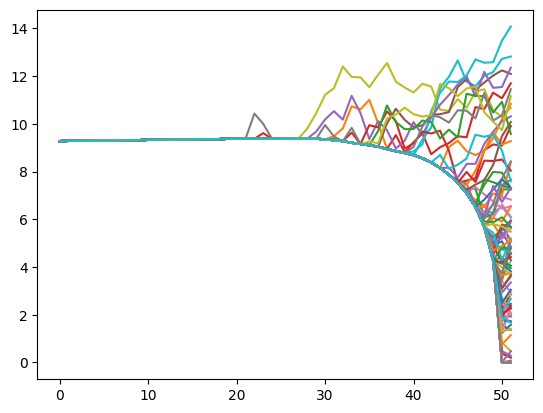

In [22]:
# sampled option paths, for later times t we notice that for OTM options the value occasionally becomes negative,
# this is due to the fact that we choose beta such that the mean squared error over all samples is minimized,
# without the constraint that the approximation of V should be nonnegative.
for n in range(N):
    pathAsRow = sampleV[n,:]
    plt.plot(pathAsRow.transpose())

In [23]:
holdValues = np.zeros(len(times)-1)


# Page 18 (Lokeshwar): Bermudan put on a single asset

In [24]:
# set parameters
S0, K, r, sigma, T, M = 40, 40, 0.06, 0.2, 1, 10
p = 32

In [25]:
# define phi for 1-dimensional vector
def phi(x: float):
  return max(x, 0)

In [26]:
# define output network
def G(beta_tm, S_tm):
  network_output = beta_tm[3*p]
  for i in range(p):
      network_output += beta_tm[2*p + i]*phi(beta_tm[i]*S_tm + beta_tm[p+i]) 

In [27]:
from helpers import forward, bs_put, bs_call
import tensorflow as tf
from tensorflow import keras
import numpy as np


In [28]:
# compute continuation value Qtm (for ease of notation we write tm where the book writes t_{m-1})
def Qt_mminus1(beta_tm, S_tm, Deltat_mplus1):
  """
  Deltat_mplus1 = t_{m+1} - t_m
  """
  sumCondExp = beta_tm[3*p]
  for i in range(p):
    w_i, b_i, omega_i = beta_tm[i], beta_tm[p+i], beta_tm[2*p+i]
    if w_i >= 0 and b_i >= 0:
      condExp = forward(w_i*S_tm + b_i, r, Deltat_mplus1)
    elif w_i >= 0 and b_i < 0:
      condExp = w_i * bs_call(S_tm, -b_i/w_i, Deltat_mplus1, r, sigma)
    elif w_i < 0 and b_i >= 0:
      condExp = -w_i * bs_put(S_tm, -b_i/w_i, Deltat_mplus1, r, sigma)
    elif w_i < 0 and b_i < 0:
      condExp = 0
    sumCondExp += omega_i*condExp
  return sumCondExp


In [29]:
monitoring_dates = np.linspace(0,T,M)
N = 100

def h(S):
  return K-S

In [38]:
def fitBeta(S_tm, V_tm, load_weights):
  x = S_tm
  y = V_tm

  model = keras.Sequential()  
  kernel_init = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)
  bias_init = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)
  model.add(keras.layers.Dense(p, input_dim=1, kernel_initializer=kernel_init, use_bias=True, bias_initializer=bias_init, activation='relu'))

  output_layer = keras.layers.Dense(1, kernel_initializer=kernel_init, use_bias=True, bias_initializer=bias_init, activation='relu')
  model.add(output_layer)
  
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt,loss='mean_squared_error')
  if load_weights==True:
    model.load_weights('model_weights.h5')
  model.fit(x, y, epochs=1000, steps_per_epoch=10)
  model.save_weights('model_weights.h5')
  return model

In [39]:
# generate paths
S = []
for n in range(N):
  path = discretizationScheme(monitoring_dates, S0, mu, sigma)
  S.append(path)
S = np.matrix(S) # (n,m)

# evaluate final time option value
V = np.zeros((N,M))
for n in range(N):
  S_T = S[n,M-1]
  V[n,M-1] = max(h(S_T), 0)

# keep track of Q to see what goes wrong
holdValues = np.zeros((N,M-1))

# initialize beta_tM
beta_tM = np.random.uniform(0,1,Np)
load_weights = False

for m in range(M,0,-1):
  # fit the network
  fit_tm = fitBeta(S[:,m-1],V[:,m-1],load_weights=load_weights)
  load_weights = True
  w1 = np.array(fit_tm.get_weights()[0][0])
  b1 = np.array(fit_tm.get_weights()[1])
  w2 = np.array(fit_tm.get_weights()[2]).flatten()
  b2 = np.array(fit_tm.get_weights()[3])
  beta_tm = np.concatenate((w1,b1,w2,b2))
  # stop when t=t0
  if m==1:
    break
  for n in range(N):
    Deltat_m = monitoring_dates[m-1] - monitoring_dates[m-2]
    St_mminus1 = S[n,m-2]
    holdValue = Qt_mminus1(beta_tm, St_mminus1, Deltat_m)
    holdValues[n, m-2] = holdValue
    V[n,m-2] = max(h(St_mminus1), holdValue)


Epoch 1/1000
10/10 [==============================] - 0s 503us/step - loss: 117287.3438
Epoch 2/1000
10/10 [==============================] - 0s 432us/step - loss: 109813.5234
Epoch 3/1000
10/10 [==============================] - 0s 460us/step - loss: 102912.2500
Epoch 4/1000
10/10 [==============================] - 0s 482us/step - loss: 96404.3828
Epoch 5/1000
10/10 [==============================] - 0s 626us/step - loss: 90513.1484
Epoch 6/1000
10/10 [==============================] - 0s 465us/step - loss: 84974.3984
Epoch 7/1000
10/10 [==============================] - 0s 498us/step - loss: 79883.0781
Epoch 8/1000
10/10 [==============================] - 0s 554us/step - loss: 75149.9531
Epoch 9/1000
10/10 [==============================] - 0s 531us/step - loss: 70773.3828
Epoch 10/1000
10/10 [==============================] - 0s 619us/step - loss: 66685.0234
Epoch 11/1000
10/10 [==============================] - 0s 533us/step - loss: 62864.0898
Epoch 12/1000
10/10 [=================

Epoch 1/1000
10/10 [==============================] - 0s 533us/step - loss: 0.4337
Epoch 2/1000
10/10 [==============================] - 0s 639us/step - loss: 0.4337
Epoch 3/1000
10/10 [==============================] - 0s 583us/step - loss: 0.4337
Epoch 4/1000
10/10 [==============================] - 0s 658us/step - loss: 0.4337
Epoch 5/1000
10/10 [==============================] - 0s 567us/step - loss: 0.4337
Epoch 6/1000
10/10 [==============================] - 0s 483us/step - loss: 0.4337
Epoch 7/1000
10/10 [==============================] - 0s 584us/step - loss: 0.4337
Epoch 8/1000
10/10 [==============================] - 0s 631us/step - loss: 0.4337
Epoch 9/1000
10/10 [==============================] - 0s 518us/step - loss: 0.4337
Epoch 10/1000
10/10 [==============================] - 0s 578us/step - loss: 0.4337
Epoch 11/1000
10/10 [==============================] - 0s 768us/step - loss: 0.4337
Epoch 12/1000
10/10 [==============================] - 0s 577us/step - loss: 0.4337
E

Epoch 1/1000
10/10 [==============================] - 0s 696us/step - loss: 0.4844
Epoch 2/1000
10/10 [==============================] - 0s 633us/step - loss: 0.4844
Epoch 3/1000
10/10 [==============================] - 0s 563us/step - loss: 0.4844
Epoch 4/1000
10/10 [==============================] - 0s 554us/step - loss: 0.4844
Epoch 5/1000
10/10 [==============================] - 0s 556us/step - loss: 0.4844
Epoch 6/1000
10/10 [==============================] - 0s 520us/step - loss: 0.4844
Epoch 7/1000
10/10 [==============================] - 0s 537us/step - loss: 0.4844
Epoch 8/1000
10/10 [==============================] - 0s 670us/step - loss: 0.4844
Epoch 9/1000
10/10 [==============================] - 0s 545us/step - loss: 0.4844
Epoch 10/1000
10/10 [==============================] - 0s 531us/step - loss: 0.4844
Epoch 11/1000
10/10 [==============================] - 0s 528us/step - loss: 0.4844
Epoch 12/1000
10/10 [==============================] - 0s 818us/step - loss: 0.4844
E

Epoch 1/1000
10/10 [==============================] - 0s 632us/step - loss: 0.3940
Epoch 2/1000
10/10 [==============================] - 0s 616us/step - loss: 0.3940
Epoch 3/1000
10/10 [==============================] - 0s 580us/step - loss: 0.3940
Epoch 4/1000
10/10 [==============================] - 0s 504us/step - loss: 0.3940
Epoch 5/1000
10/10 [==============================] - 0s 706us/step - loss: 0.3940
Epoch 6/1000
10/10 [==============================] - 0s 554us/step - loss: 0.3940
Epoch 7/1000
10/10 [==============================] - 0s 563us/step - loss: 0.3940
Epoch 8/1000
10/10 [==============================] - 0s 557us/step - loss: 0.3940
Epoch 9/1000
10/10 [==============================] - 0s 568us/step - loss: 0.3940
Epoch 10/1000
10/10 [==============================] - 0s 563us/step - loss: 0.3940
Epoch 11/1000
10/10 [==============================] - 0s 445us/step - loss: 0.3940
Epoch 12/1000
10/10 [==============================] - 0s 583us/step - loss: 0.3940
E

Epoch 1/1000
10/10 [==============================] - 0s 522us/step - loss: 0.4692
Epoch 2/1000
10/10 [==============================] - 0s 645us/step - loss: 0.4692
Epoch 3/1000
10/10 [==============================] - 0s 555us/step - loss: 0.4692
Epoch 4/1000
10/10 [==============================] - 0s 542us/step - loss: 0.4692
Epoch 5/1000
10/10 [==============================] - 0s 606us/step - loss: 0.4692
Epoch 6/1000
10/10 [==============================] - 0s 458us/step - loss: 0.4692
Epoch 7/1000
10/10 [==============================] - 0s 585us/step - loss: 0.4692
Epoch 8/1000
10/10 [==============================] - 0s 623us/step - loss: 0.4692
Epoch 9/1000
10/10 [==============================] - 0s 478us/step - loss: 0.4692
Epoch 10/1000
10/10 [==============================] - 0s 518us/step - loss: 0.4692
Epoch 11/1000
10/10 [==============================] - 0s 714us/step - loss: 0.4692
Epoch 12/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.4692
Epo

Epoch 1/1000
10/10 [==============================] - 0s 679us/step - loss: 0.5354
Epoch 2/1000
10/10 [==============================] - 0s 540us/step - loss: 0.5354
Epoch 3/1000
10/10 [==============================] - 0s 524us/step - loss: 0.5354
Epoch 4/1000
10/10 [==============================] - 0s 578us/step - loss: 0.5354
Epoch 5/1000
10/10 [==============================] - 0s 602us/step - loss: 0.5354
Epoch 6/1000
10/10 [==============================] - 0s 549us/step - loss: 0.5354
Epoch 7/1000
10/10 [==============================] - 0s 520us/step - loss: 0.5354
Epoch 8/1000
10/10 [==============================] - 0s 572us/step - loss: 0.5354
Epoch 9/1000
10/10 [==============================] - 0s 518us/step - loss: 0.5354
Epoch 10/1000
10/10 [==============================] - 0s 557us/step - loss: 0.5354
Epoch 11/1000
10/10 [==============================] - 0s 519us/step - loss: 0.5354
Epoch 12/1000
10/10 [==============================] - 0s 486us/step - loss: 0.5354
E

Epoch 1/1000
10/10 [==============================] - 0s 605us/step - loss: 0.5982
Epoch 2/1000
10/10 [==============================] - 0s 501us/step - loss: 0.5982
Epoch 3/1000
10/10 [==============================] - 0s 585us/step - loss: 0.5982
Epoch 4/1000
10/10 [==============================] - 0s 462us/step - loss: 0.5982
Epoch 5/1000
10/10 [==============================] - 0s 560us/step - loss: 0.5982
Epoch 6/1000
10/10 [==============================] - 0s 563us/step - loss: 0.5982
Epoch 7/1000
10/10 [==============================] - 0s 597us/step - loss: 0.5982
Epoch 8/1000
10/10 [==============================] - 0s 588us/step - loss: 0.5982
Epoch 9/1000
10/10 [==============================] - 0s 512us/step - loss: 0.5982
Epoch 10/1000
10/10 [==============================] - 0s 686us/step - loss: 0.5982
Epoch 11/1000
10/10 [==============================] - 0s 469us/step - loss: 0.5982
Epoch 12/1000
10/10 [==============================] - 0s 611us/step - loss: 0.5982
E

Epoch 1/1000
10/10 [==============================] - 0s 544us/step - loss: 0.4703
Epoch 2/1000
10/10 [==============================] - 0s 594us/step - loss: 0.4703
Epoch 3/1000
10/10 [==============================] - 0s 503us/step - loss: 0.4703
Epoch 4/1000
10/10 [==============================] - 0s 591us/step - loss: 0.4703
Epoch 5/1000
10/10 [==============================] - 0s 557us/step - loss: 0.4703
Epoch 6/1000
10/10 [==============================] - 0s 510us/step - loss: 0.4703
Epoch 7/1000
10/10 [==============================] - 0s 623us/step - loss: 0.4703
Epoch 8/1000
10/10 [==============================] - 0s 520us/step - loss: 0.4703
Epoch 9/1000
10/10 [==============================] - 0s 585us/step - loss: 0.4703
Epoch 10/1000
10/10 [==============================] - 0s 463us/step - loss: 0.4703
Epoch 11/1000
10/10 [==============================] - 0s 599us/step - loss: 0.4703
Epoch 12/1000
10/10 [==============================] - 0s 512us/step - loss: 0.4703
E

Epoch 1/1000
10/10 [==============================] - 0s 642us/step - loss: 0.3495
Epoch 2/1000
10/10 [==============================] - 0s 583us/step - loss: 0.3495
Epoch 3/1000
10/10 [==============================] - 0s 578us/step - loss: 0.3495
Epoch 4/1000
10/10 [==============================] - 0s 531us/step - loss: 0.3495
Epoch 5/1000
10/10 [==============================] - 0s 602us/step - loss: 0.3495
Epoch 6/1000
10/10 [==============================] - 0s 598us/step - loss: 0.3495
Epoch 7/1000
10/10 [==============================] - 0s 506us/step - loss: 0.3495
Epoch 8/1000
10/10 [==============================] - 0s 527us/step - loss: 0.3495
Epoch 9/1000
10/10 [==============================] - 0s 557us/step - loss: 0.3495
Epoch 10/1000
10/10 [==============================] - 0s 615us/step - loss: 0.3495
Epoch 11/1000
10/10 [==============================] - 0s 613us/step - loss: 0.3495
Epoch 12/1000
10/10 [==============================] - 0s 577us/step - loss: 0.3495
E

Epoch 1/1000
10/10 [==============================] - 0s 663us/step - loss: 0.0000e+00
Epoch 2/1000
10/10 [==============================] - 0s 576us/step - loss: 0.0000e+00
Epoch 3/1000
10/10 [==============================] - 0s 598us/step - loss: 0.0000e+00
Epoch 4/1000
10/10 [==============================] - 0s 516us/step - loss: 0.0000e+00
Epoch 5/1000
10/10 [==============================] - 0s 611us/step - loss: 0.0000e+00
Epoch 6/1000
10/10 [==============================] - 0s 520us/step - loss: 0.0000e+00
Epoch 7/1000
10/10 [==============================] - 0s 589us/step - loss: 0.0000e+00
Epoch 8/1000
10/10 [==============================] - 0s 482us/step - loss: 0.0000e+00
Epoch 9/1000
10/10 [==============================] - 0s 573us/step - loss: 0.0000e+00
Epoch 10/1000
10/10 [==============================] - 0s 510us/step - loss: 0.0000e+00
Epoch 11/1000
10/10 [==============================] - 0s 511us/step - loss: 0.0000e+00
Epoch 12/1000
10/10 [====================

In [41]:
print(V[0,:])

[ 0.         -0.63225169 -0.57971685 -0.51487307 -0.47309632 -0.45769119
 -0.38114005 -0.30125966 -0.23678475  0.        ]


In [33]:
print(S[0,:])

[[40.         40.42514548 40.4084219  41.94255844 43.36344374 44.14423951
  44.59872816 44.90615182 44.47849569 45.82633578]]


In [34]:
print(holdValues[0,:])

[0.98455177 0.93121062 1.14597541 0.99113125 1.01998221 1.03867712
 1.1326506  0.77579431 0.79187055]
